In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지


In [2]:
df = pd.read_csv('data.csv')
df1 = df[df['label']=='time']

In [3]:
df1

,label,T [degC],P [bar],W_cat [g],Time [h],N_Gly [mmol],N_KOH [mmol],N_H2 [mmol],N_LA [mmol],N_PDO [mmol],N_FA [mmol],N_GA [mmol],N_ME [mmol],N_EG [mmol]
0,time,200,15.518495,0.3,0.0,250.00,375.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,time,200,59.476671,0.3,0.5,118.00,251.034139,115.931722,114.077674,12.051221,5.429530,4.458657,0.927012,0.927012
2,time,200,81.907079,0.3,1.0,44.75,184.831070,175.087859,174.250005,20.945948,8.209457,7.709468,2.094585,2.094585
3,time,200,86.897811,0.3,1.5,30.00,170.874995,188.250011,188.249996,21.828120,8.187502,7.687508,1.984380,1.984380
4,time,200,92.654542,0.3,2.0,14.00,155.283828,203.432345,201.249991,22.830920,9.608083,8.858098,2.685998,2.685998
5,time,200,92.352269,0.3,2.5,5.00,151.182423,202.635155,203.750011,28.986492,10.783777,9.283789,2.229713,2.229713


In [4]:
# parameters initialization
Wi = 66.625
VL = 41.253968 # mL# h2 solubility parameter
p00 = 0.2638
p01 = 5.443e-4
p02 = -2.45e-7
p10 = -1.545e-3
p20 = 2.205e-6
p11 = 9.105e-7
mw_h2o = 18 # g/mol, water molweight
mw_h2 = 2 # g/mol, hydrogen molweight

In [5]:
# Concentration initialization
N0 = np.array([
    df1.iloc[0]['N_Gly [mmol]'],    # 글리세롤
    df1.iloc[0]['N_KOH [mmol]'],    # KOH
    df1.iloc[0]['N_H2 [mmol]'],     # 수소
    df1.iloc[0]['N_LA [mmol]'],     # 젖산
    df1.iloc[0]['N_PDO [mmol]'],    # 1,3-PDO
    df1.iloc[0]['N_FA [mmol]'],     # 포름산
    df1.iloc[0]['N_GA [mmol]'],     # 글리콜산
    df1.iloc[0]['N_ME [mmol]'],     # 메탄올
    df1.iloc[0]['N_EG [mmol]']      # 에틸렌글리콜
], dtype=np.float32)

N_exp = np.array([
    df1.iloc[0:]['N_Gly [mmol]'].values,    # 글리세롤 0
    df1.iloc[0:]['N_KOH [mmol]'].values,    # KOH 1
    df1.iloc[0:]['N_H2 [mmol]'].values,     # 수소 2
    df1.iloc[0:]['N_LA [mmol]'].values,     # 젖산 3
    df1.iloc[0:]['N_PDO [mmol]'].values,    # 1,3-PDO 4
    df1.iloc[0:]['N_FA [mmol]'].values,     # 포름산 5
    df1.iloc[0:]['N_GA [mmol]'].values,     # 글리콜산 6
    df1.iloc[0:]['N_ME [mmol]'].values,     # 메탄올 7
    df1.iloc[0:]['N_EG [mmol]'].values      # 에틸렌글리콜 8
], dtype=np.float32)

In [6]:
def ode_system(t, N, k_params):

    wcat = 0.3*0.02 # Pt 함량 0.3 g의 2%
    wpet = 0.3

    VL = 41.253968 # mL
    VG = 145 - VL
    C = N/VL # mmol/mL = M
    

    
    T = 200.0
    P_H2O = 10**(8.14019-1810.94/(244.485+T))/750.062 # Antoine equation
    vg = 8.314*(T+273.15)/(P_H2O*1e5)
    NG_H2O = 1/(vg*1e3)*VG

    P_H2 = (N[2]/1e3)/(VG/1e6)*8.314*(T+273.15)/1e5
    S_H2 = p00 + (T)*p10 + P_H2*p01 + (T)**2*p20 + P_H2**2*p02 + (T)*P_H2*p11
    WL = Wi - (N[2])*mw_h2/1000 - NG_H2O*mw_h2o/1000
    NL_H2 = S_H2*WL
    NLf_H2 = min(N[2], NL_H2)

    C[2] = NLf_H2/VL
        # C의 0인 성분을 1e-8로 수정
    C[C < 0] = 1e-8
    # kg1 0 # KGly 1 # KH2 2 # KPDO 3 # kd1 4 # kd2 5 # kd3 6 # kp1 7 # kp2 8

    # 글리세롤 0 # KOH 1 # 수소 2 # 젖산 3 # 1,3-PDO 4 # 포름산 5 # 글리콜산 6 # 메탄올 7 # 에틸렌글리콜 8
    
    # parameter
    k = 10**k_params
    
    # Intensive reaction rate
    theta = 1 + k[1]*C[0] + (k[2]*C[2])**0.5 + k[3]*C[4]
    rg1= k[0]*k[1]*C[0]/(theta**3) # Glycerol -> DHA + H2
    rd1 = k[4] # DHA -> PRA + H2O
    rd2 = k[5]*(C[1]**2) # DHA + 2KOH -> FA + GA + 2H2
    rd3 = k[6]*(C[2]**2) # DHA + 2H2 -> ME + EG
    rp1 = k[7]*C[1] # PRA + KOH -> LA
    rp2 = k[8]*k[2]**2*C[2]**2/(theta**5)# PRA + 2H2 -> PDO

    # Extensive reaction rate
    rg1_ext = rg1*wcat
    rd1_ext = rd1*VL/1000
    rd2_ext = rd2*VL/1000
    rd3_ext = rd3*VL/1000
    rp1_ext = rp1*VL/1000
    rp2_ext = rp2*wcat

    # Fractional conversion
    fd1 = rd1_ext/(rd1_ext+rd2_ext+rd3_ext)
    fd2 = rd2_ext/(rd1_ext+rd2_ext+rd3_ext)
    fd3 = rd3_ext/(rd1_ext+rd2_ext+rd3_ext)

    fp1 = rp1_ext/(rp1_ext+rp2_ext)
    fp2 = rp2_ext/(rp1_ext+rp2_ext)

    dN0dt = -rg1_ext
    dN1dt = -2*rg1_ext*fd2 - rg1_ext*fd1*fp1
    dN2dt = rg1_ext + 2*rg1_ext*fd2 - 2*rg1_ext*fd3 - 2*rg1_ext*fd1*fp2
    dN3dt = rg1_ext*fd1*fp1
    dN4dt = rg1_ext*fd1*fp2
    dN5dt = rg1_ext*fd2
    dN6dt = rg1_ext*fd2
    dN7dt = rg1_ext*fd3
    dN8dt = rg1_ext*fd3

    return np.array([dN0dt, dN1dt, dN2dt, dN3dt, dN4dt, dN5dt, dN6dt, dN7dt, dN8dt])


In [7]:
t_eval = np.array(df1.iloc[0:]['Time [h]'].values, dtype=np.float32)
t_eval
t_span=(t_eval[0], t_eval[-1])
t_span

(np.float32(0.0), np.float32(2.5))

In [8]:
def solve_ode(k_params, t_eval, y0):
    sol = solve_ivp(
        ode_system,
        t_span=(t_eval[0], t_eval[-1]),
        y0=y0,
        t_eval=t_eval,
        args=(k_params,),
        method='RK45'
    )
    return sol.y

In [9]:
def objective_function(k_params):
    try:
        N_pred = solve_ode(k_params, t_eval, N0)
        
        # 마스킹할 데이터 위치 정의
        mask = np.ones_like(N_exp, dtype=bool)
        mask[4,-1] = False  # t=2.5에서의 PDO
        mask[7,4] = False   # t=2에서의 ME 
        mask[8,4] = False   # t=2에서의 EG
        mask[5,-1] = False  # t=2.5에서의 FA
        
        # 각 성분별 최대값으로 normalize
        N_exp_max = np.max(np.abs(N_exp), axis=1)
        N_exp_max = np.where(N_exp_max == 0, 1, N_exp_max)  # 0으로 나누기 방지
        
        # normalize된 error 계산 (마스킹 적용)
        squared_errors = ((N_pred - N_exp) / N_exp_max.reshape(-1,1))**2
        normalized_error = np.mean(squared_errors[mask])
        return normalized_error
    except:
        return 1e10

In [10]:
best_loss = float('inf')
best_x = np.ones(9)
x0 = np.ones(9)
for i in range(70):  # 10번 반복
    result = minimize(
        objective_function,
        x0=x0,
        method='L-BFGS-B',
        bounds=[(-20, 20) for _ in range(len(x0))]  # 모든 변수에 대해 -10 ~ 10 범위 제한
    )
    
    # 현재 시도의 loss 출력
    print(f'시도 {i+1} - Loss: {result.fun:.6f}, Best Loss: {best_loss:.6f}')
    
    if result.fun < best_loss:
        best_loss = result.fun
        best_x = result.x.copy()
        x0 = result.x.copy()  # 더 나은 결과를 얻은 경우 x0를 result.x로 갱신
    else:
        x0 = best_x.copy()  # 더 나은 결과를 얻지 못한 경우 best_x를 x0로 사용
        
    # x0에 랜덤 변화 추가
    x0 = x0 * (1 + np.random.randn(len(x0)) * 0.1)


시도 1 - Loss: 0.485110, Best Loss: inf
시도 2 - Loss: 0.485110, Best Loss: 0.485110
시도 3 - Loss: 0.485110, Best Loss: 0.485110
시도 4 - Loss: 0.485110, Best Loss: 0.485110
시도 5 - Loss: 0.485110, Best Loss: 0.485110
시도 6 - Loss: 0.485109, Best Loss: 0.485110
시도 7 - Loss: 0.485109, Best Loss: 0.485109
시도 8 - Loss: 0.485110, Best Loss: 0.485109
시도 9 - Loss: 0.485110, Best Loss: 0.485109
시도 10 - Loss: 0.485110, Best Loss: 0.485109
시도 11 - Loss: 0.485110, Best Loss: 0.485109
시도 12 - Loss: 0.485109, Best Loss: 0.485109
시도 13 - Loss: 0.485110, Best Loss: 0.485109
시도 14 - Loss: 0.485110, Best Loss: 0.485109
시도 15 - Loss: 0.485109, Best Loss: 0.485109
시도 16 - Loss: 0.485107, Best Loss: 0.485109
시도 17 - Loss: 0.485109, Best Loss: 0.485107
시도 18 - Loss: 0.485108, Best Loss: 0.485107
시도 19 - Loss: 0.485108, Best Loss: 0.485107
시도 20 - Loss: 0.485109, Best Loss: 0.485107
시도 21 - Loss: 0.485107, Best Loss: 0.485107
시도 22 - Loss: 0.485107, Best Loss: 0.485107
시도 23 - Loss: 0.485106, Best Loss: 0.485107
시도

In [11]:
result.x

array([ 8.80325801,  1.25562047,  1.92032393,  2.25454535,  8.53517428,
       -1.48647385, -3.29588915, -3.65340957,  5.126601  ])

In [12]:
best_x

array([ 8.5641127 ,  1.2004235 ,  1.67194224,  2.11098041,  2.30826975,
       -0.74828249,  2.16900121, -4.01684163,  4.70028739])

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/tmp/ipykernel_38760/1472981742.py:17: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_38760/1472981742.py:17: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfo

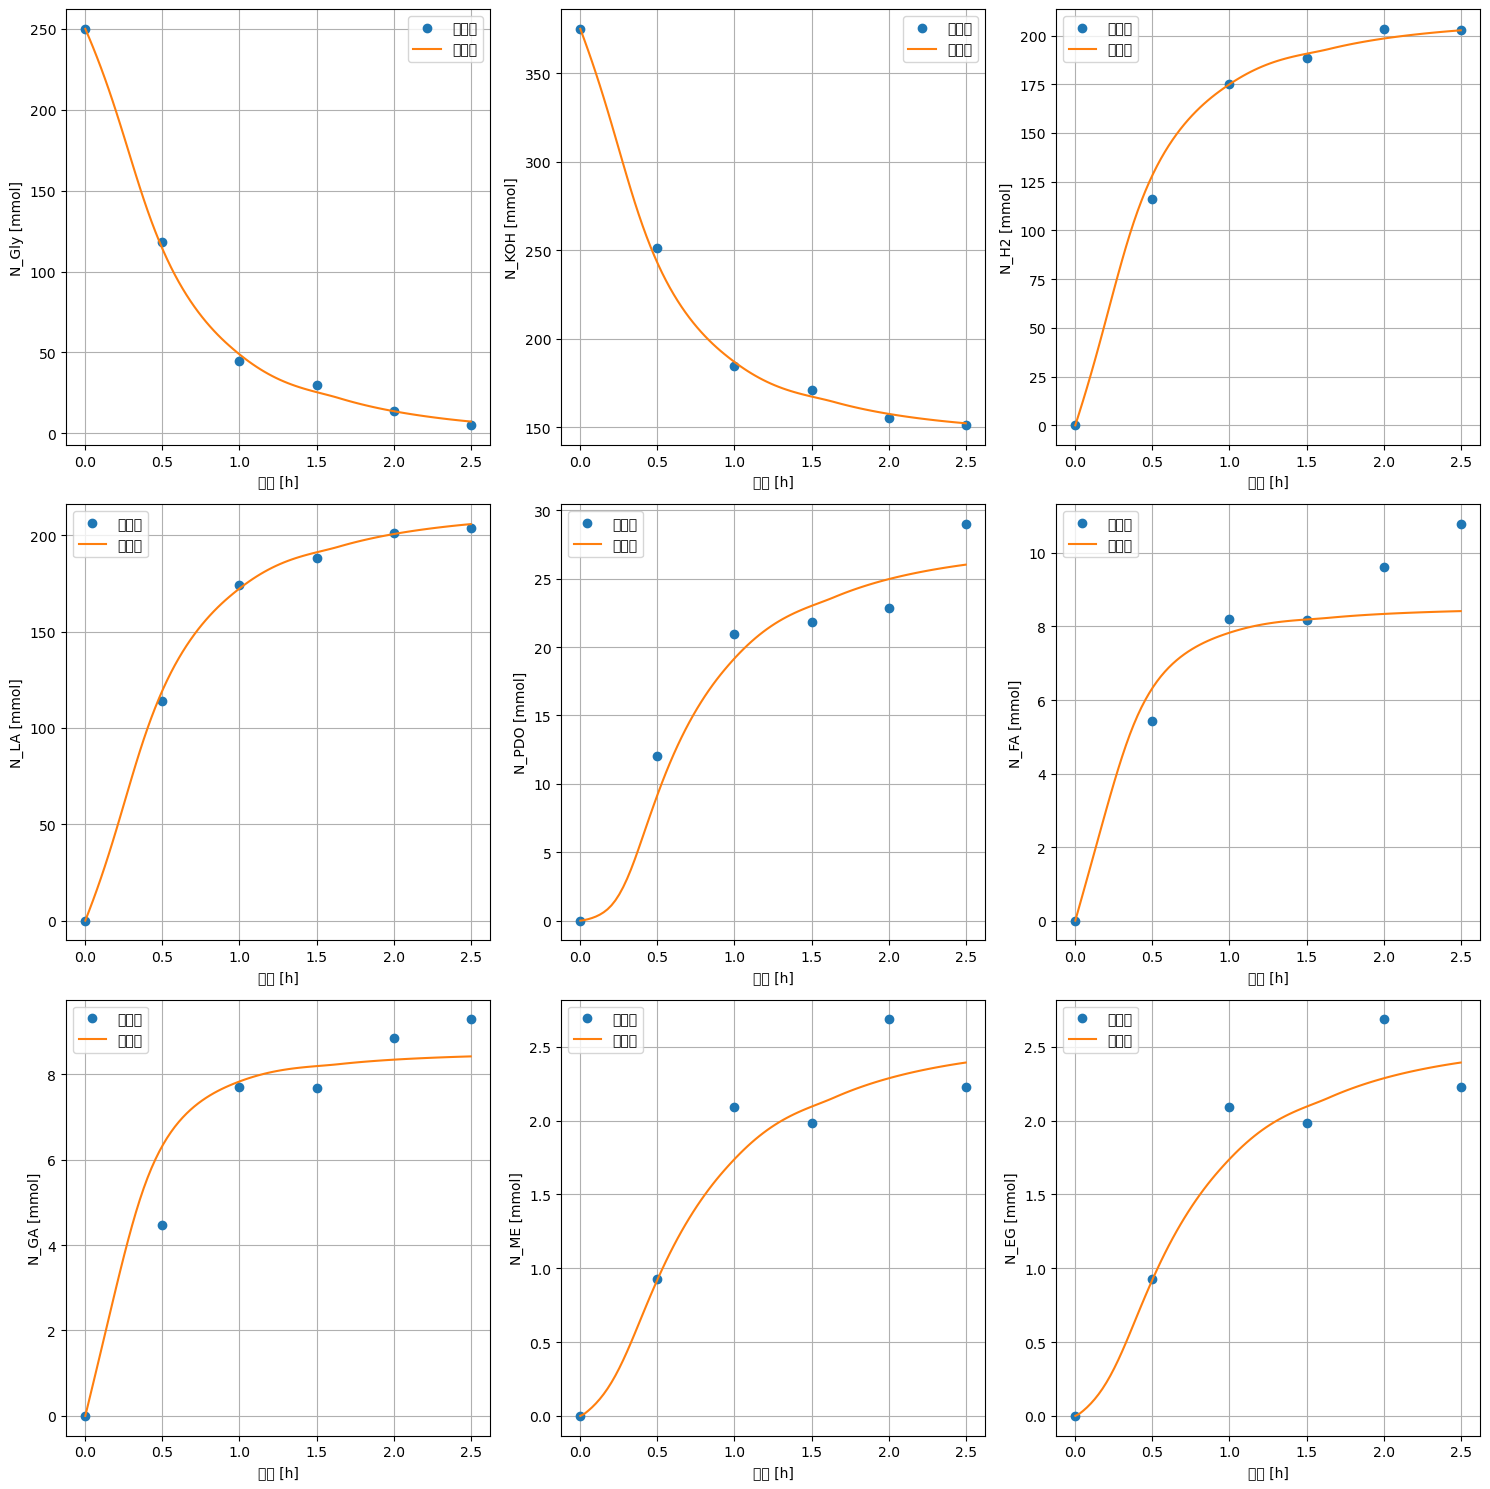

In [13]:
# 예측값 계산을 위한 더 조밀한 시간 격자 생성
t_pred = np.linspace(t_eval[0], t_eval[-1], 100)
N_pred = solve_ode(best_x, t_pred, N0)

# 성분별 비교 그래프 그리기
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
components = ['Gly', 'KOH', 'H2', 'LA', 'PDO', 'FA', 'GA', 'ME', 'EG']

for i, (ax, comp) in enumerate(zip(axes.flat, components)):
    ax.plot(t_eval, N_exp[i], 'o', label='실험값')
    ax.plot(t_pred, N_pred[i], '-', label='예측값')
    ax.set_xlabel('시간 [h]')
    ax.set_ylabel(f'N_{comp} [mmol]')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [14]:
result.fun

np.float64(0.19384411390656373)

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/home/sjbaek/miniforge3/envs/torchenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sjbaek/miniforge3/envs/torchenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(

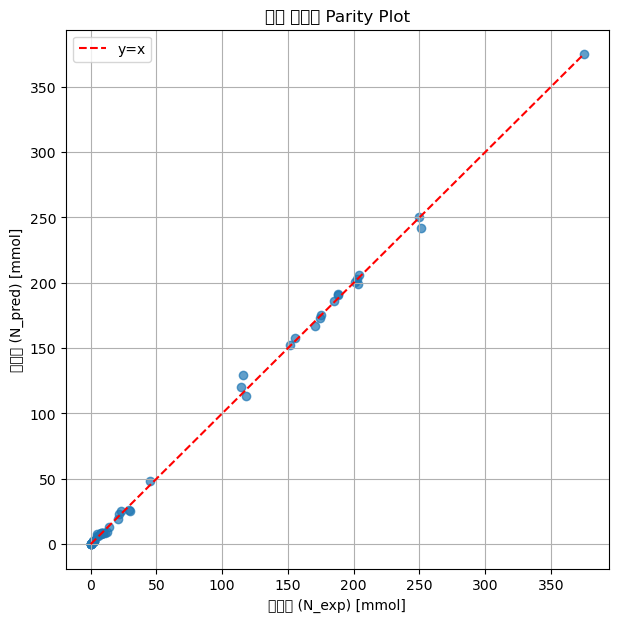

전체 데이터 R2: 0.9990


In [15]:
# 전체 데이터에 대한 parity plot과 R2 계산

from sklearn.metrics import r2_score

# 예측값과 실험값을 1차원 배열로 합치기
N_exp_all = np.concatenate([N_exp[i] for i in range(len(components))])
N_pred_all = np.concatenate([N_pred[i, np.searchsorted(t_pred, t_eval)] for i in range(len(components))])

# Parity plot
plt.figure(figsize=(7,7))
plt.scatter(N_exp_all, N_pred_all, alpha=0.7)
plt.plot([N_exp_all.min(), N_exp_all.max()], [N_exp_all.min(), N_exp_all.max()], 'r--', label='y=x')
plt.xlabel('실험값 (N_exp) [mmol]')
plt.ylabel('예측값 (N_pred) [mmol]')
plt.title('전체 데이터 Parity Plot')
plt.legend()
plt.grid(True)
plt.show()

# R2 계산
r2 = r2_score(N_exp_all, N_pred_all)
print(f"전체 데이터 R2: {r2:.4f}")
